# Project 5d-SIR models in SPACE

Until now, we have been approaching disease models in a way that lumps spatial information: entire population classes, despite the fact that humans are geographically separated, are treated as single variables (S,I, or R).  However, it is possible to simulate disease propagation at rather different levels of detail.  One very interesting and very detailed way is to use agent-based models, which means that every single person in the environment is treated individually.  Such models are quite expensive to run.  Another way is a lattice SIR model, which is what we will explore in this section (partially as a means of motivating our next class of model).  

The lattice model is very simple.  Instead of modelling an entire population via a single S, I, and R, we will define an $n\times n$ grid and each location on the grid will have its own SIR status (to be concrete, you could represent these by three numpy arrays).  At each of these locations $k$, we might have dynamics like
$$
\frac{\partial S_{k}}{\partial t} = -\beta S_{k} I_{k}
$$
$$
\frac{\partial I_{k}}{\partial t} = \beta S_{k} I_{k} - \gamma I_{k}
$$
$$
\frac{\partial R_{k}}{\partial t} = \gamma I_{k}.
$$
However, this wouldn't be a very interesting model because each of the locations on the grid are independent from one another.  Instead, we would like adjacent grid cells to be *coupled* (this is similar to the Game of Life).  What sort of coupling makes sense?  There are many possible situations that we could model now that we have some spatial dependency.  One simple possibility states that: rather than susceptible individuals being converted into infected individuals as $-\beta S_{k} I_{k}$, we could have that  
$$
\frac{\partial S_{k}}{\partial t} = -\beta S_{k}\; \sum_{j\in adj(k)} \frac{I_j}{9},
$$
(with a similar modification to the rate of change in infected) which is to say that the infection probability is now proportional to the average number of infected individuals in the cells adjacent to $k$. 

**Implement and run the model described above. Begin by using $n=50$, $\beta=1$, and $\gamma=0.1$.  Assume periodic boundary conditions.  Start with only a single grid cell somewhere in the domain containing an infected individual.**  A few hints for modifying your code: just like with the molecular dynamics problem, you'll need to figure out a way to map from a vector of variables of size $3N$, with $N=n^2$ to the S, I, and R values at each location in a grid.  Internally within my rhs function I (for example) took the first $N$ elements in my vector to be my $S$ values and then explicitly reshaped them back into a grid using np.reshape.  At the end of this function, I turned grid variables back into a vector using np.ravel and concatenation.  For computing the spatial average, I suggest the convolve2d function from scipy.signal (pay attention to the keyword arguments for easy implementation of boundaries, in particular boundary='wrap').

In [1]:
import numpy as np
from scipy.signal import convolve2d
import ode_methods as om
import matplotlib.pyplot as plt
import matplotlib.animation as animation

class SpatialSIR:
    def __init__(self, n=50, beta=1, gamma=0.1):
        self.n = n # number of cells in each direction
        self.beta = beta # infection rate
        self.gamma = gamma # recovery rate
        self.kernel = np.ones((3, 3)) / 9 # used for convolution to compute the number of infected neighbors
        self.n_dof = 3 * n * n # number of degrees of freedom (S, I, R for each cell)
        self.u0 = np.zeros(self.n_dof) # initial conditions
        self.u0[:n*n] = 1  # All cells are susceptible (value of 1 since S + I + R = 1 for each cell)
        self.u0[n*n + n//2*n-10 + n//2] = 1  # One cell is infected

    def rhs(self, t, u):
        # here we assume periodic boundary conditions
        # in th the 1d array, the first n*n elements are the susceptibles, the next n*n are the infected, and the last n*n are the recovered
        # we must reshape the arrays to 2D arrays to perform the convolution
        S = u[:self.n*self.n].reshape((self.n, self.n))
        I = u[self.n*self.n:2*self.n*self.n].reshape((self.n, self.n))
        R = u[2*self.n*self.n:].reshape((self.n, self.n))

        # now we compute the right-hand side of the ODE
        # the convolve2d function computes the number of infected neighbors using the kernel.
        # in this case, the kernel is a 3x3 matrix with all elements equal to 1/9
        dSdt = -self.beta * S * convolve2d(I, self.kernel, mode='same', boundary='wrap')
        dIdt = self.beta * S * convolve2d(I, self.kernel, mode='same', boundary='wrap') - self.gamma * I
        dRdt = self.gamma * I

        # we flatten the arrays to a 1D array since the ODE solver expects a 1D array
        return np.concatenate((dSdt.ravel(), dIdt.ravel(), dRdt.ravel()))

    def run(self, method, t_span, dt):
        integrator = om.Integrator(self, method)
        t, u = integrator.integrate(t_span, dt, self.u0)
        return t, u

In [10]:
len(s.u0[:50*50])

2500

In [4]:
method = om.Heun()
s = SpatialSIR()
t, u = s.run(method, [0, 100], 0.01)

# u is a 2D array, we reshape it to a 3D array to plot the results
S = u[:, :s.n*s.n].reshape((-1, s.n, s.n))
I = u[:, s.n*s.n:2*s.n*s.n].reshape((-1, s.n, s.n))
R = u[:, 2*s.n*s.n:].reshape((-1, s.n, s.n))

**Animate the solution (I suggest repurposing code from Conway's Game of Life).  Describe the patterns that you see of the population classes in space and time.** 

In [ ]:
# matplotlib animate the grid over time

# fig, ax = plt.subplots()
# im = ax.imshow(I[0])

# def update(i):
#     im.set_data(I[i])
#     return im, # comma after is for tuple

# ani = animation.FuncAnimation(fig, update, frames=range(0, len(t), 10), blit=True)
# # colorbar
# fig.colorbar(im)
# ani.save('sir.mp4', fps=20)
# plt.show()

In [ ]:
# plot the number of infected individuals over time
plt.plot(t, np.sum(I, axis=(1, 2)))
plt.xlabel('Time')
plt.ylabel('Number of infected individuals')
plt.show()

### Barriers
We can utilize this model to explore the influence of geographic barriers to disease propagation.  First, modify your code to accept a spatially varying value of $\beta$, i.e. 
$$
\frac{\partial S_{k}}{\partial t} = -\beta_k S_{k}\; \sum_{j\in adj(k)} \frac{I_j}{9}.
$$
Second, modify your boundary conditions to *not* be periodic.  If you used scipy.convolve, then you can do this by changing the boundary keyword to 'symm'.    

**Now, create a simulation that utilizes a barrier.  For example, you might set the middle 1/3 of the domain to have $\beta=0$.  How does the simulation change?  If the barrier is imperfect, does the disease still reach the other side?**

In [27]:
# basically the same as the previous class, but beta is just a 2D array now so we can set it to zero in the middle box

class SpatialSIRBarrier:
    def __init__(self, n=50, beta=1, gamma=0.1):
        self.n = n # number of cells in each direction
        self.beta = beta # infection rate
        self.gamma = gamma # recovery rate
        self.kernel = np.ones((3, 3)) / 9 # used for convolution to compute thekernel number of infected neighbors
        self.n_dof = 3 * n * n # number of degrees of freedom (S, I, R for each cell)
        self.u0 = np.zeros(self.n_dof) # initial conditions
        self.u0[:n*n] = 1  # All cells are susceptible (value of 1 since S + I + R = 1 for each cell)
        self.u0[n*n + n//2*n-10 + n//2] = 1  # One cell is infected
        self.beta = np.ones((n, n))
        self.beta[n//3:2*n//3, n//3:2*n//3] = 0 # set beta to zero in the middle box
        # add openings to the box on all 4 sides
        self.beta[n//3-1, n//3-1:2*n//3+1] = 1
        self.beta[2*n//3, n//3-1:2*n//3+1] = 1
        self.beta[n//3-1:2*n//3+1, n//3-1] = 1
        self.beta[n//3-1:2*n//3+1, 2*n//3] = 1
        # # set beta to be a line down the center of the grid
        # self.beta[:, n//2] = 0
        # # add an opening in the middle of the centered vertical barrier
        # self.beta[n//2-1:n//2+2, n//2] = 1

    def rhs(self, t, u):
        # here we assume periodic boundary conditions
        # in th the 1d array, the first n*n elements are the susceptibles, the next n*n are the infected, and the last n*n are the recovered
        # we must reshape the arrays to 2D arrays to perform the convolution
        S = u[:self.n*self.n].reshape((self.n, self.n))
        I = u[self.n*self.n:2*self.n*self.n].reshape((self.n, self.n))
        R = u[2*self.n*self.n:].reshape((self.n, self.n))

        # now we compute the right-hand side of the ODE
        # the convolve2d function computes the number of infected neighbors using the kernel.
        # in this case, the kernel is a 3x3 matrix with all elements equal to 1/9
        dSdt = -self.beta * S * convolve2d(I, self.kernel, mode='same', boundary='symm')
        dIdt = self.beta * S * convolve2d(I, self.kernel, mode='same', boundary='symm') - self.gamma * I
        dRdt = self.gamma * I

        # we flatten the arrays to a 1D array since the ODE solver expects a 1D array
        return np.concatenate((dSdt.ravel(), dIdt.ravel(), dRdt.ravel()))
    
    def run(self, method, t_span, dt):
        integrator = om.Integrator(self, method)
        t, u = integrator.integrate(t_span, dt, self.u0)
        return t, u

In [22]:
s.beta

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [24]:
method = om.Heun()
s = SpatialSIRBarrier()
t, u = s.run(method, [0, 100], 0.01)

# u is a 2D array, we reshape it to a 3D array to plot the results
S = u[:, :s.n*s.n].reshape((-1, s.n, s.n))
I = u[:, s.n*s.n:2*s.n*s.n].reshape((-1, s.n, s.n))
R = u[:, 2*s.n*s.n:].reshape((-1, s.n, s.n))

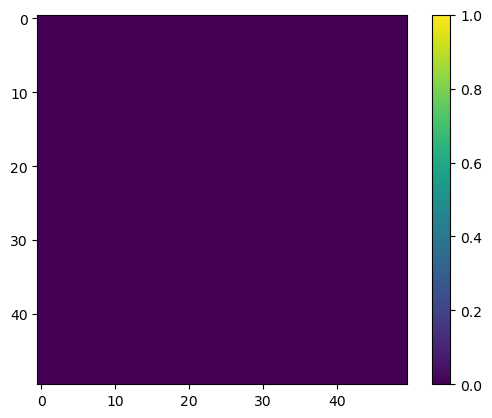

In [25]:
# animate
fig, ax = plt.subplots()
im = ax.imshow(I[0])
import matplotlib.animation as animation
def update(i):
    im.set_data(I[i])
    return im, # comma after is for tuple

ani = animation.FuncAnimation(fig, update, frames=range(0, len(t), 10), blit=True)
# colorbar
fig.colorbar(im)
ani.save('sir_barrier.mp4', fps=20)
plt.show()

In [ ]:
import pygame
import numpy as np

# Initialize Pygame
pygame.init()

# Define screen size and create screen
screen_size = (800, 800)
screen = pygame.display.set_mode(screen_size)

# Define a function to map I values to colors
def get_color(i):
    return (255 * i, 0, 255 * (1 - i))

# Calculate the size of each cell
cell_size = screen_size[0] // s.n, screen_size[1] // s.n

# Main loop
running = True
while running:
    # Clear screen
    screen.fill((0, 0, 0))

    # Draw cells
    for i in range(s.n):
        for j in range(s.n):
            # Determine the color of the cell based on I value
            color = get_color(I[i, j])

            # Draw the cell
            pygame.draw.rect(screen, color, pygame.Rect(i*cell_size[0], j*cell_size[1], cell_size[0], cell_size[1]))

    # Update screen
    pygame.display.flip()

    # Delay to control speed of animation
    pygame.time.delay(100)

    # Handle events
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

# Quit Pygame
pygame.quit()

/tmp/ipykernel_156924/1067830990.py:90: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread("frames/" + str(counter)+ ".png"))


KeyboardInterrupt: 

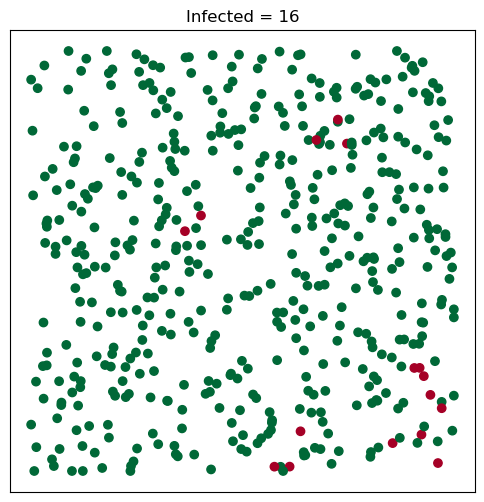

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from scipy.spatial import distance_matrix

class Agent():
    def __init__(self,x,y,infected,resistance,infectedCounter = 0):
        #initalize position
        self.x = x
        self.y = y
        self.infected = infected
        self.resistance = resistance
        self.infectedCounter = infectedCounter 
        
    def movement(self,stepSize,xBounds,yBounds):
        #step
        self.x += stepSize*np.random.uniform(-1,1)
        self.y += stepSize*np.random.uniform(-1,1)
        
        #check boundaries
        if self.x < xBounds[0]:
            self.x = xBounds[0]
        elif self.x > xBounds[1]:
            self.x = xBounds[1]
        
        if self.y < yBounds[0]:
            self.y = yBounds[0]
        elif self.y > yBounds[1]:
            self.y = yBounds[1]
            
        #Tick down infeced counter
        if self.infected == True:
            self.infectedCounter -= 1
            if self.infectedCounter <= 0:
                self.infected = False
        
    def infect(self):
        infectRoll = np.random.uniform()
        
        if self.infected == False and infectRoll > self.resistance:
            self.infected = True
            self.infectedCounter = 50
            self.resistance *= 1.5

def getPosition(agents):
    positions = []
    for agent in agents:
        positions.append([agent.x,agent.y])
    positions = np.array(positions)
    return positions

def moveAgents(agents,stepSize,xBounds,yBounds):
    for i in range(0,len(agents)):
        agents[i].movement(stepSize,xBounds,yBounds)
    return agents

def getInfected(agents):
    infected  = []
    for agent in agents:
        infected.append(agent.infected)
    return infected

def getCloseAgents(distanceMatrix,agentNumber):
    sort = np.argsort(distanceMatrix[agentNumber])
    closeMask = distanceMatrix[agentNumber][sort] < 10
    closeAgents = np.argsort(distanceMatrix[agentNumber])[closeMask][1:]
    return closeAgents

def rollInfect(agents):
    positions = getPosition(agents)
    distanceMatrix = distance_matrix(positions,positions)
    for i in range(0,len(agents)):
        closeAgents = getCloseAgents(distanceMatrix,i)
        for j in closeAgents:
            if agents[j].infected == True:
                agents[i].infect()
    return agents

def makeGif(frames,name):
    !mkdir frames
    
    counter=0
    images = []
    for i in range(0,len(frames)):
        plt.figure(figsize = (6,6))
        plt.scatter(frames[i][0],frames[i][1], c = frames[i][2], cmap = "RdYlGn_r")
        plt.title("Infected = " + str(np.sum(frames[i][2])))
        plt.tick_params(left = False, right = False , labelleft = False,labelbottom = False, bottom = False)
        plt.savefig("frames/" + str(counter)+ ".png")
        images.append(imageio.imread("frames/" + str(counter)+ ".png"))
        counter += 1
        plt.close()
        
    imageio.mimsave(name, images)
    
    !rm -r frames

agents = []
for i in range(0,500):
    x = np.random.uniform(0,500)
    y = np.random.uniform(0,500)
    agents.append(Agent(x,y,0,.3))
    
for i in range(0,10):
    agents[i].infected = 1
    agents[i].infectedCounter = 50
    
stepSize = 5
xBounds = [0,500]
yBounds = [0,500]

frames = []
for i in range(0,500):
    agents = moveAgents(agents,stepSize,xBounds,yBounds)
    agents = rollInfect(agents)
    positions = getPosition(agents)
    infected = getInfected(agents)
    frames.append([positions[:,0] , positions[:,1], infected])
    
makeGif(frames,"Simulation.gif")